In [1]:
import torch

BATCH_SIZE = 30
EPOCHS = 30
LEARNING_RATE = 3e-2
SEED = 0

c:\python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('../data/mm_mc_train_data.txt')
val_labels, val_data = read_data('../data/mm_mc_dev_data.txt')
test_labels, test_data = read_data('../data/mm_mc_test_data.txt')

Use one between the following two: BobcatParser or spiders_reader

In [5]:
from lambeq import BobcatParser

parser = BobcatParser(model_name_or_path='D:/Stefano/Documents/Python/Jupyter/QNLP/model/')

train_diagrams = parser.sentences2diagrams(train_data)
val_diagrams = parser.sentences2diagrams(val_data)
test_diagrams = parser.sentences2diagrams(test_data)

In [13]:
from lambeq import spiders_reader

train_diagrams = spiders_reader.sentences2diagrams(train_data)
val_diagrams = spiders_reader.sentences2diagrams(val_data)
test_diagrams = spiders_reader.sentences2diagrams(test_data)

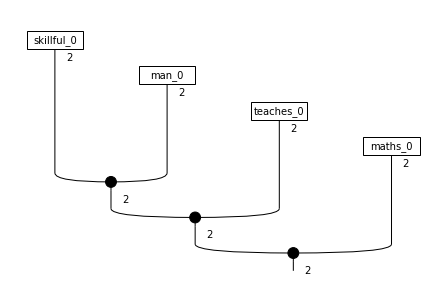

In [14]:
from discopy import Dim

from lambeq import AtomicType, SpiderAnsatz

ansatz = SpiderAnsatz({AtomicType.NOUN: Dim(2),
                       AtomicType.SENTENCE: Dim(2)})

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
val_circuits =  [ansatz(diagram) for diagram in val_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw()

In [15]:
from lambeq import PytorchModel

all_circuits = train_circuits + val_circuits + test_circuits
model = PytorchModel.from_diagrams(all_circuits)

In [16]:
sig = torch.sigmoid

def accuracy(y_hat, y):
    return torch.sum(torch.eq(torch.round(sig(y_hat)), y))/len(y)/2  # half due to double-counting

eval_metrics = {"acc": accuracy}

In [17]:
from lambeq import PytorchTrainer

trainer = PytorchTrainer(
        model=model,
        loss_function=torch.nn.BCEWithLogitsLoss(),
        optimizer=torch.optim.AdamW,
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='text',
        seed=SEED)

In [18]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

In [19]:
trainer.fit(train_dataset, val_dataset, evaluation_step=1, logging_step=5)

Epoch 1:   train/loss: 0.6905   valid/loss: 0.6876   train/acc: 0.5188   valid/acc: 0.4500
Epoch 5:   train/loss: 0.6208   valid/loss: 0.6351   train/acc: 0.7500   valid/acc: 0.7750
Epoch 10:  train/loss: 0.4079   valid/loss: 0.3824   train/acc: 0.8250   valid/acc: 0.8750
Epoch 15:  train/loss: 0.2262   valid/loss: 0.1694   train/acc: 0.8750   valid/acc: 0.8750
Epoch 20:  train/loss: 0.1643   valid/loss: 0.1240   train/acc: 0.9000   valid/acc: 0.9000
Epoch 25:  train/loss: 0.0583   valid/loss: 0.0308   train/acc: 1.0000   valid/acc: 1.0000
Epoch 30:  train/loss: 0.0028   valid/loss: 0.0018   train/acc: 1.0000   valid/acc: 1.0000

Training completed!


Test accuracy: 1.0


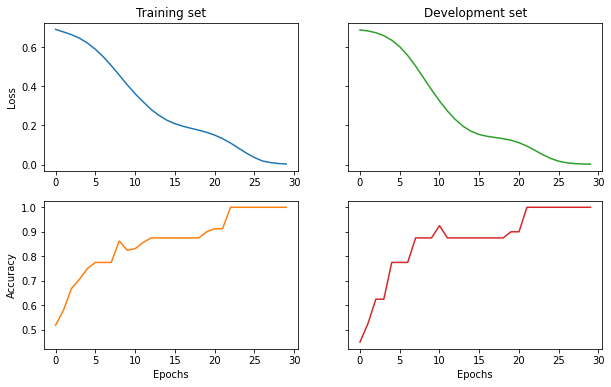

In [20]:
import matplotlib.pyplot as plt

fig1, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharey='row', figsize=(10, 6))

ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Epochs')
ax_br.set_xlabel('Epochs')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

# print test accuracy
test_acc = accuracy(model(test_circuits), torch.tensor(test_labels))
print('Test accuracy:', test_acc.item())